In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("../datasets/students_simple.csv")

In [2]:
df.head()

,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


In [3]:
N = 17
x = df.iloc[:, N % 5]
y = df.iloc[:, (N ** 2) % 5 + 5]

In [4]:
mean_x, mean_y = np.mean(x), np.mean(y)
sign_x = np.sign(x - mean_x)
sign_y = np.sign(y - mean_y)
n_same = np.sum(sign_x * sign_y > 0)
n_diff = np.sum(sign_x * sign_y < 0)
corr_fechner = (n_same - n_diff) / len(x)
corr_fechner

np.float64(-0.4)

In [5]:
x_norm = x - x.mean()
y_norm = y - y.mean()
pirson = np.sum(x_norm * y_norm) / (x.shape[0] * np.std(x_norm) * np.std(y_norm))
pirson

np.float64(-0.5698939517430254)

In [6]:
alpha = 0.05
z = np.arctanh(pirson)
se = 1 / np.sqrt(len(x) - 3)
z_crit = stats.norm.ppf(1 - alpha / 2)
ci_low, ci_high = np.tanh([z - z_crit * se, z + z_crit * se])

In [7]:
print(ci_low, ci_high)

-0.8085153217834531 -0.1703282324387952


In [9]:
def rank_array(arr):
    temp = arr.argsort()
    ranks = np.empty_like(temp, dtype=float)
    ranks[temp] = np.arange(1, len(arr) + 1)
    
    unique, inv, counts = np.unique(arr, return_inverse=True, return_counts=True)
    for i, count in enumerate(counts):
        if count > 1:
            ranks[inv == i] = np.mean(ranks[inv == i])
    return ranks

rx = rank_array(x)
ry = rank_array(y)
d = rx - ry
spearman = 1 - (6 * np.sum(d**2)) / (len(x) * (len(x)**2 - 1))
print(spearman)

n_concordant = 0
n_discordant = 0
for i in range(len(x) - 1):
    for j in range(i + 1, len(x)):
        diff_x = x[i] - x[j]
        diff_y = y[i] - y[j]
        prod = diff_x * diff_y
        if prod > 0:
            n_concordant += 1
        elif prod < 0:
            n_discordant += 1
kendall = (n_concordant - n_discordant) / (0.5 * len(x) * (len(x) - 1))
print(kendall)

-0.5368421052631578
-0.43157894736842106


Наблюдается обратная зависимость между признаками

(array([2., 3., 1., 1., 1., 3., 1., 0., 0., 2., 0., 2., 1., 1., 0., 0., 1.,
        0., 0., 1.]),
 array([290. , 317.5, 345. , 372.5, 400. , 427.5, 455. , 482.5, 510. ,
        537.5, 565. , 592.5, 620. , 647.5, 675. , 702.5, 730. , 757.5,
        785. , 812.5, 840. ]),
 <BarContainer object of 20 artists>)

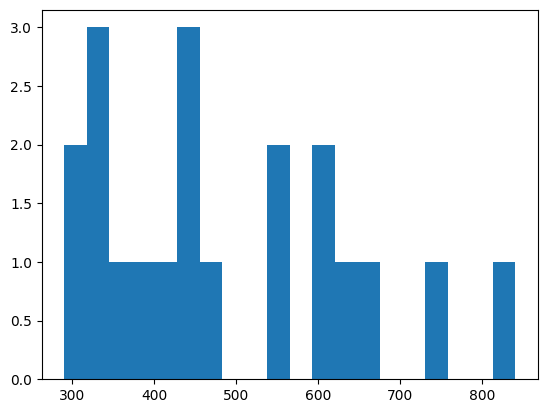

In [10]:
plt.hist(x, bins=len(x))

(array([1., 1., 2., 0., 0., 1., 2., 1., 2., 1., 1., 2., 0., 1., 2., 1., 0.,
        0., 1., 1.]),
 array([ 3.5 ,  3.95,  4.4 ,  4.85,  5.3 ,  5.75,  6.2 ,  6.65,  7.1 ,
         7.55,  8.  ,  8.45,  8.9 ,  9.35,  9.8 , 10.25, 10.7 , 11.15,
        11.6 , 12.05, 12.5 ]),
 <BarContainer object of 20 artists>)

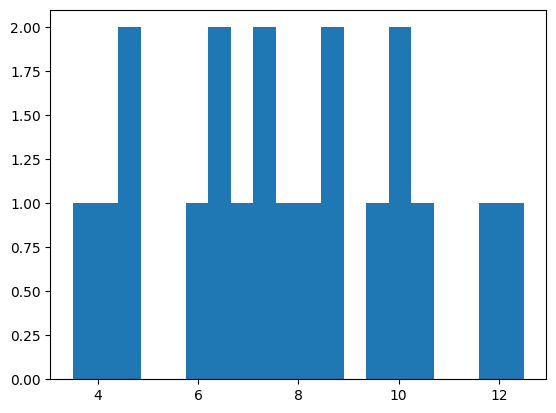

In [11]:
plt.hist(y, bins=len(x))

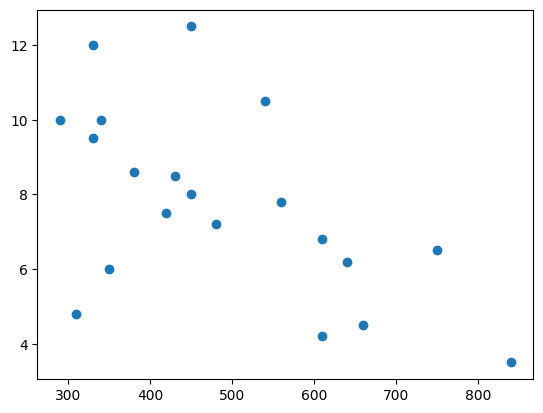

In [12]:
plt.scatter(x,y)

Наблюдается слабая линейная зависимость признаков

In [13]:
from sklearn.linear_model import LinearRegression

x_ = x.to_numpy().reshape(-1, 1)
lin_reg = LinearRegression().fit(x_, y)
sq_reg = LinearRegression().fit(np.concat([x_, x_ ** 2], axis=1), y)
hyp_reg = LinearRegression().fit(1 / x_, y)
log_reg = LinearRegression().fit(x_, np.log(y))

In [29]:
from scipy import stats

def fisher(y_true, y_pred, k=1, alpha=0.05):
    n = len(y_true)
    
    # R² coefficient
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot

    # F-statistic
    F = (r2 / k) / ((1 - r2) / (n - k - 1))

    # critical value
    F_crit = stats.f.ppf(1 - alpha, k, n - k - 1)

    print(f"R² = {r2:.4f}")
    print(f"F_calc = {F:.4f}")
    print(f"F_crit = {F_crit:.4f}")

    if F > F_crit:
        print("Model is statistically significant (fits data well)")
    else:
        print("Model is not statistically significant (fits poorly)")

    return F, F_crit, r2


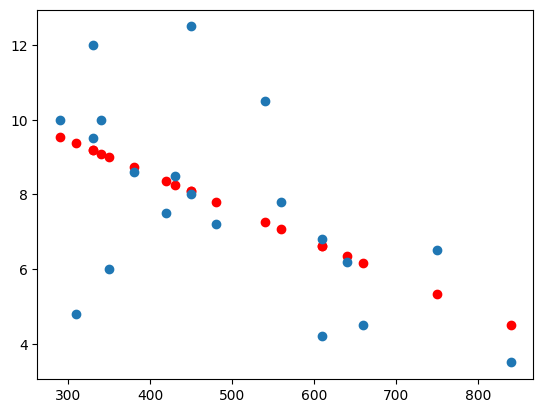

In [30]:
plt.scatter(x_, lin_reg.predict(x_), color="red")
plt.scatter(x_, y)
plt.show()

In [31]:
fisher(lin_reg.predict(x_), y)

R² = -1.0790
F_calc = -9.3421
F_crit = 4.4139
Model is not statistically significant (fits poorly)


(np.float64(-9.34205675098935),
 np.float64(4.413873419170566),
 np.float64(-1.0790157064216))

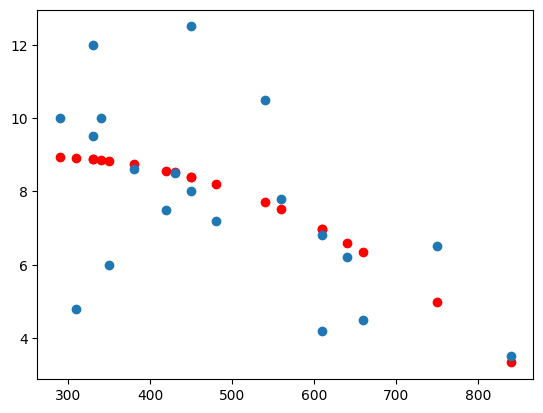

In [32]:

plt.scatter(x_, sq_reg.predict(np.concat([x_, x_ ** 2], axis=1)), color="red")
plt.scatter(x_, y)
plt.show()

In [33]:
fisher(sq_reg.predict(np.concat([x_, x_ ** 2], axis=1)), y)

R² = -0.8235
F_calc = -8.1286
F_crit = 4.4139
Model is not statistically significant (fits poorly)


(np.float64(-8.128643110023035),
 np.float64(4.413873419170566),
 np.float64(-0.8234575246971954))

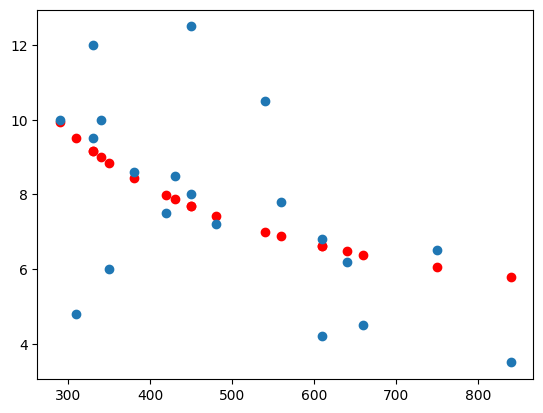

In [34]:
plt.scatter(x_, hyp_reg.predict(1 / x_), color="red")
plt.scatter(x_, y)
plt.show()

In [35]:
fisher(hyp_reg.predict(1 / x_), y)

R² = -2.1191
F_calc = -12.2291
F_crit = 4.4139
Model is not statistically significant (fits poorly)


(np.float64(-12.229096862820697),
 np.float64(4.413873419170566),
 np.float64(-2.1190958455071254))

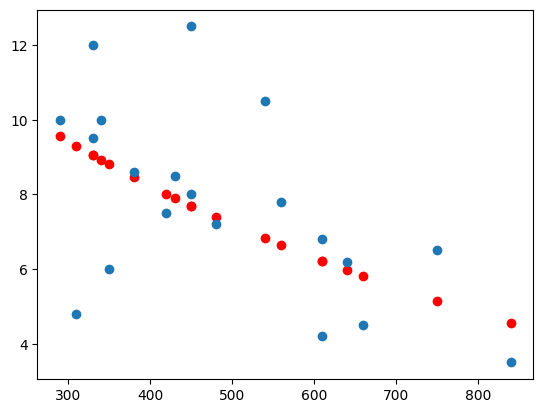

In [36]:
plt.scatter(x_, np.exp(log_reg.predict(x_)), color="red")
plt.scatter(x_, y)
plt.show()

In [37]:
fisher(np.exp(log_reg.predict(x_)),y)

R² = -1.0752
F_calc = -9.3259
F_crit = 4.4139
Model is not statistically significant (fits poorly)


(np.float64(-9.325949977971751),
 np.float64(4.413873419170566),
 np.float64(-1.0751551990463466))

Лучше всего справилась гипербола, хуже всего квадратичная